# Deep Reinforcement Learning for Portfolio Optimization


This experiment demonstrates the application of Deep Reinforcement Learning (DRL) algorithms (`A2C`, `PPO`, `SAC`) for portfolio optimization.

**Workflow**

1. Downloads & preprocesses Dow 30 data
2. Engineers features & computes covariances
3. Splits into train/test sets with validation
4. Configures Gym environment with tunable parameters
5. Trains `A2C`, `PPO`, and `SAC` with hyperparameter options
6. Backtests strategies and computes risk-adjusted stats
7. Builds a minimum-variance benchmark
8. Plots comparative returns
9. Provides commented options for further tuning and validation


## Dependencies


In [8]:
# ! pip install pandas numpy matplotlib \
#                stable-baselines3 \
#                PyPortfolioOpt \
#                pandas_market_calendars quantstats gymnasium \
#                git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [9]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from stable_baselines3 import A2C, PPO, SAC

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

# import quantstats as qs

# Set up matplotlib for inline plotting
%matplotlib inline

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
experiment_name = "mlp_basic"
results_dir = f"results/models/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

## Configure train/trade date ranges

Define the date ranges for training, validation, and trading(testing)


In [10]:
train_start = "2015-01-01"
train_end = "2023-12-31"

trade_start = "2024-01-01"
trade_end = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")

print(f"Train: '{train_start}' to '{train_end}'")
print(f"Trade: '{trade_start}' to '{trade_end}'")

Train: '2015-01-01' to '2023-12-31'
Trade: '2024-01-01' to '2025-04-25'


# Load data


In [11]:
ticker_list = config_tickers.DOW_30_TICKER
start_date = train_start
end_date = trade_end

display(f"Downloading data from {start_date} to {end_date}")
display(f"Tickers: {ticker_list}")

df = YahooDownloader(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list
).fetch_data()

'Downloading data from 2015-01-01 to 2025-04-25'

"Tickers: ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']"

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (76731, 8)


## Preprocess data and append technical indicators


In [12]:
print("Preprocessing data...")
# TODO: Test with turbulence
fe = FeatureEngineer(use_technical_indicator=True, use_turbulence=False)
df_tech = fe.preprocess_data(df)

print(f"df_tech shape: {df_tech.shape}")

Preprocessing data...
Successfully added technical indicators
df_tech shape: (75197, 16)


# Covariance & Returns for State

Rolling window of 252 trading days → build `cov_list` and `return_list`.


In [13]:
print("Computing covariance matrices...")

df_sorted = df_tech.sort_values(["date", "tic"], ignore_index=True)
df_sorted.index = df_sorted.date.factorize()[0]

cov_list, return_list = [], []
lookback = 252
unique_dates = df_sorted.date.unique()

for i in range(lookback, len(unique_dates)):
    window = df_sorted.loc[i - lookback : i]
    price_mat = window.pivot_table(index="date", columns="tic", values="close")
    ret_mat = price_mat.pct_change().dropna()
    return_list.append(ret_mat)
    cov_list.append(ret_mat.cov().values)

# Merge back
df_cov = pd.DataFrame(
    {"date": unique_dates[lookback:], "cov_list": cov_list, "return_list": return_list}
)
df_merged = pd.merge(df_tech, df_cov, on="date", how="left")
df_final = df_merged[df_merged["cov_list"].notna()].reset_index(drop=True)

print(f"df_final shape with cov_list: {df_final.shape}")
assert (
    "cov_list" in df_final.columns
), "cov_list missing ― check lookback or merge logic"

Computing covariance matrices...
df_final shape with cov_list: (67889, 18)


## Train/Trade split

Split by date-range


In [14]:
train_data = data_split(df_final, train_start, train_end)
trade_data = data_split(df_final, trade_start, trade_end)

print(f"Train data: {train_data.shape}")
print(f"Trade data: {trade_data.shape}")

Train data: (58348, 18)
Trade data: (9541, 18)


## Environment setup


In [15]:
stock_dim = len(train_data.tic.unique())
state_space = stock_dim
tech_indicators = config.INDICATORS

env_kwargs = {
    "stock_dim": stock_dim,
    "hmax": 100,
    "initial_amount": 1e6,
    "transaction_cost_pct": 0.001,
    "reward_scaling": 1e-4,
    "state_space": state_space,
    "action_space": stock_dim,
    "tech_indicator_list": tech_indicators,
    "turbulence_threshold": 100,  # TODO: Set a threshold for turbulence. Penalize extreme volatility
}
print(
    f"""Stock Dim: {stock_dim}
    State Space: {state_space}
    Indicators: {tech_indicators}"""
)


# Create Gym environments
e_train = StockPortfolioEnv(df=train_data, **env_kwargs)
env_train, _ = e_train.get_sb_env()
e_trade = StockPortfolioEnv(df=trade_data, **env_kwargs)

Stock Dim: 29
    State Space: 29
    Indicators: ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']


## Train DRL agents


In [16]:
# Flag to use manual parameters
use_manual_params = False

# Hyperparameters for the different algorithms
A2C_PARAMS = {"learning_rate": 7e-5, "ent_coef": 0.01, "n_steps": 5}
PPO_PARAMS = {"learning_rate": 3e-4, "ent_coef": 0.02, "n_steps": 128, "batch_size": 64}
SAC_PARAMS = {"learning_rate": 3e-4, "buffer_size": 50000, "learning_starts": 1000}
DDPG_PARAMS = {
    "learning_rate": 1e-3,
    "buffer_size": 100000,
    "learning_starts": 1000,
    "batch_size": 64,
}

algos = ["a2c", "ppo", "sac", "ddpg"]
trained_models = {}
training_times = {}

for algo in algos:
    start_time = time.time()
    print(f"Training {algo.upper()}...")
    agent = DRLAgent(env=env_train)
    if algo == "a2c":
        model = agent.get_model(
            "a2c", model_kwargs=A2C_PARAMS if use_manual_params else {}
        )
    elif algo == "ppo":
        model = agent.get_model(
            "ppo", model_kwargs=PPO_PARAMS if use_manual_params else {}
        )
    elif algo == "sac":
        model = agent.get_model(
            "sac", model_kwargs=SAC_PARAMS if use_manual_params else {}
        )
    elif algo == "ddpg":
        model = agent.get_model(
            "ddpg", model_kwargs=DDPG_PARAMS if use_manual_params else {}
        )

    start_time = time.time()
    trained = agent.train_model(model=model, tb_log_name=algo, total_timesteps=100_000)
    end_time = time.time()
    
    trained_models[algo] = trained
    training_times[algo.upper()] = end_time - start_time


Training A2C...
{}
Using cpu device
-------------------------------------
| time/                 |           |
|    fps                | 891       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -40.8     |
|    explained_variance | 1.79e-07  |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 1.86e+08  |
|    reward             | 1532196.0 |
|    std                | 0.988     |
|    value_loss         | 2.48e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 935       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -40.9     |
|    explained_variance | -1.19e-07 |
|    learning_

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.71GB > 5.57GB
  warnings.warn(


begin_total_asset:1000000.0
end_total_asset:3024617.6408578334
Sharpe:  0.8633886125780494
begin_total_asset:1000000.0
end_total_asset:3028353.629452003
Sharpe:  0.8641350046145705
begin_total_asset:1000000.0
end_total_asset:3028487.882514931
Sharpe:  0.8641833109168436
begin_total_asset:1000000.0
end_total_asset:3028359.072977937
Sharpe:  0.864138033065463
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 78        |
|    time_elapsed    | 103       |
|    total_timesteps | 8048      |
| train/             |           |
|    actor_loss      | -5.96e+07 |
|    critic_loss     | 2.14e+11  |
|    ent_coef        | 11.3      |
|    ent_coef_loss   | -263      |
|    learning_rate   | 0.0003    |
|    n_updates       | 7947      |
|    reward          | 3028359.0 |
----------------------------------
begin_total_asset:1000000.0
end_total_asset:3029372.111487105
Sharpe:  0.8643925766384564
begin_total_asset:1000000

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.71GB > 4.72GB
  warnings.warn(


begin_total_asset:1000000.0
end_total_asset:3160940.0813153153
Sharpe:  0.8826181025184621
begin_total_asset:1000000.0
end_total_asset:3184568.235274967
Sharpe:  0.8885049601258012
begin_total_asset:1000000.0
end_total_asset:3184568.235274967
Sharpe:  0.8885049601258012
begin_total_asset:1000000.0
end_total_asset:3184568.235274967
Sharpe:  0.8885049601258012
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 60        |
|    time_elapsed    | 133       |
|    total_timesteps | 8048      |
| train/             |           |
|    actor_loss      | -6.35e+07 |
|    critic_loss     | 5.11e+11  |
|    learning_rate   | 0.001     |
|    n_updates       | 7947      |
|    reward          | 3184568.2 |
----------------------------------
begin_total_asset:1000000.0
end_total_asset:3184568.235274967
Sharpe:  0.8885049601258012
begin_total_asset:1000000.0
end_total_asset:3184568.235274967
Sharpe:  0.8885049601258012
begi

In [ ]:
print("Training Summary:")
display((pd.DataFrame(training_times, index=["Time (s)"]).T))

Save trained models


In [ ]:
def save_trained_models(trained_models, results_dir):
    for algo, model in trained_models.items():
        model_path = f"{results_dir}/{algo}_model"
        model.save(model_path)
        print(f"Saved {algo.upper()} model to {model_path}")

In [ ]:
def save_trained_models(trained_models, results_dir):
    for algo, model in trained_models.items():
        model_path = f"{results_dir}/{algo}_model"
        model.save(model_path)
        print(f"Saved {algo.upper()} model to {model_path}")

save_trained_models(trained_models, experiment_name)

Model a2c saved to results/models/po_experiment_1/a2c_model
Model ppo saved to results/models/po_experiment_1/ppo_model
Model sac saved to results/models/po_experiment_1/sac_model
Model ddpg saved to results/models/po_experiment_1/ddpg_model


Load saved models


In [ ]:
def load_trained_models(results_dir):
    loaded_models = {}
    for algo in algos:
        model_path = f"{results_dir}/{algo}_model"
        loaded_models[algo] = DRLAgent.load(model_path)
        print(f"Loaded {algo.upper()} model from {model_path}")
    return loaded_models

loaded_models = load_trained_models(experiment_name)

In [18]:
if "trained_models" not in locals() or not trained_models:
    # Check if model files exist before loading
    model_paths = {
        "a2c": "results/models/a2c_trained_model.zip",
        "ppo": "results/models/ppo_trained_model.zip",
        "sac": "results/models/sac_trained_model.zip",
    }

    if all(os.path.exists(path) for path in model_paths.values()):
        trained_models = {
            "a2c": A2C.load(model_paths["a2c"]),
            "ppo": PPO.load(model_paths["ppo"]),
            "sac": SAC.load(model_paths["sac"]),
        }
        print("Models loaded successfully.")
    else:
        print(
            "One or more model files are missing. Please ensure all models are saved correctly."
        )
else:
    print("Trained models are already set up.")

Trained models are already set up.


## Backtest DRL strategies


In [19]:
results = {}
for algo, model in trained_models.items():
    print(f"Backtesting {algo.upper()}...")
    df_ret, _ = DRLAgent.DRL_prediction(model=model, environment=e_trade)
    # Reconstruct cumulative account value from daily returns
    df_ret["account_value"] = (df_ret["daily_return"] + 1).cumprod() * env_kwargs[
        "initial_amount"
    ]
    stats = backtest_stats(df_ret, value_col_name="account_value")
    results[algo] = {"df": df_ret, "stats": stats}

    # QuantStats report:
    # qs.reports.html(df_ret['daily_return'], output=f'results/{algo}_quantstats.html')

Backtesting A2C...
begin_total_asset:1000000.0
end_total_asset:1085293.320137618
Sharpe:  0.4781084421393164
hit end!
Annual return          0.064701
Cumulative returns     0.085293
Annual volatility      0.156838
Sharpe ratio           0.478835
Calmar ratio           0.426782
Stability              0.663571
Max drawdown          -0.151602
Omega ratio            1.095675
Sortino ratio          0.698619
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.928858
Daily value at risk   -0.019462
dtype: float64
Backtesting PPO...
begin_total_asset:1000000.0
end_total_asset:1090835.00266784
Sharpe:  0.5192735451371725
hit end!
Annual return          0.068862
Cumulative returns     0.090835
Annual volatility      0.149926
Sharpe ratio           0.520063
Calmar ratio           0.468576
Stability              0.696529
Max drawdown          -0.146961
Omega ratio            1.103919
Sortino ratio          0.754528
Skew                        NaN
Kurtosis      

## Minimum-Variance Benchmark

Construct a rolling min‑variance portfolio for comparison.


In [20]:
print("Building min‑variance portfolio...")

dates = trade_data.date.unique()
min_var_vals = [env_kwargs["initial_amount"]]
for i in range(len(dates) - 1):
    df_curr = trade_data[trade_data.date == dates[i]].reset_index(drop=True)
    df_next = trade_data[trade_data.date == dates[i + 1]].reset_index(drop=True)
    cov_mat = np.array(df_curr.cov_list.values[0])
    ef = EfficientFrontier(None, cov_mat, weight_bounds=(0, 1))
    ef.min_volatility()
    w = ef.clean_weights()
    prices = df_curr.close.values
    next_prices = df_next.close.values
    shares = np.array(list(w.values())) * min_var_vals[-1] / prices
    min_var_vals.append(np.dot(shares, next_prices))

min_var_df = pd.DataFrame({"date": dates, "account_value": min_var_vals})

Building min‑variance portfolio...


## DJIA benchmark

Fetch DJIA and compute daily returns


In [21]:
print("Fetching DJIA benchmark...")

baseline = get_baseline(ticker="^DJI", start=trade_start, end=trade_end)
baseline_ret = get_daily_return(baseline, "close")

Fetching DJIA benchmark...


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (329, 8)


## Plot cumulative returns

Visualize DRL vs. min‑var vs. DJIA


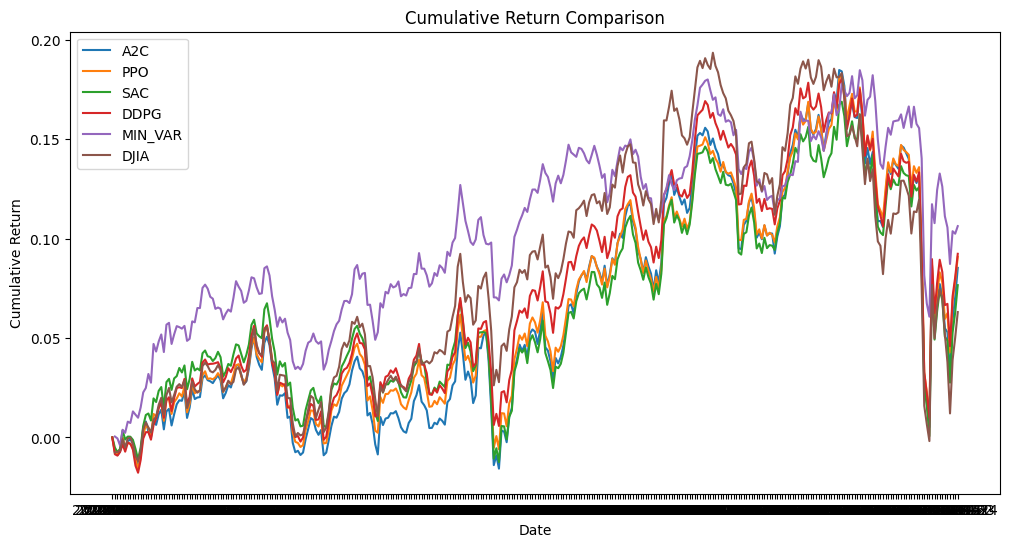

In [22]:
plt.figure(figsize=(12, 6))
for algo in algos:
    df_ret = results[algo]["df"]
    cump = (df_ret["daily_return"] + 1).cumprod() - 1
    plt.plot(df_ret["date"], cump, label=algo.upper())

# Min-var and DJIA
c_min = (min_var_df["account_value"].pct_change() + 1).cumprod() - 1
plt.plot(min_var_df["date"], c_min, label="MIN_VAR")
c_dji = (baseline_ret + 1).cumprod() - 1
plt.plot(baseline["date"], c_dji, label="DJIA")
plt.legend()
plt.title("Cumulative Return Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.savefig("results/cumulative_return_comparison.png")
plt.show()

## Performance Summary

Tabulate key metrics (Sharpe, MaxDD, etc.) for each algorithm.


In [23]:
perf_stats = pd.DataFrame({algo.upper(): results[algo]["stats"] for algo in algos})
display(perf_stats)

,A2C,PPO,SAC,DDPG
Annual return,0.064701,0.068862,0.058159,0.070015
Cumulative returns,0.085293,0.090835,0.076596,0.092371
Annual volatility,0.156838,0.149926,0.150827,0.147130
Sharpe ratio,0.478835,0.520063,0.450872,0.534373
Calmar ratio,0.426782,0.468576,0.404108,0.484093
Stability,0.663571,0.696529,0.610679,0.693824
Max drawdown,-0.151602,-0.146961,-0.143920,-0.144632
Omega ratio,1.095675,1.103919,1.089998,1.107416
Sortino ratio,0.698619,0.754528,0.654431,0.782567
Skew,NaN,NaN,NaN,NaN
